# Soft Advice for uncritical positions
We devise a CNN-based policy, that comes up with somewhat reasonable moves by a preference to lines that are already occupied by stones of the same color and are not that much obstructed by stones of the other color. Doesn't play any smart, though!

In [1]:
import numpy as np
import tensorflow as tf

from domoku.data import create_nxnx4, create_binary_rep
from domoku.policies.softadvice import MaxInfluencePolicyParams, MaxInfluencePolicy
from domoku.tools import GomokuTools as gt
from domoku.board import GomokuBoard
from domoku.policies.radial import radial_2xnxn

In [2]:
def print_bin(binary_sample):
    binary_sample = np.squeeze(binary_sample)
    print(f'shape: {binary_sample.shape}')
    print(np.rollaxis(binary_sample, 2, 0)[0])
    print()
    print(np.rollaxis(binary_sample, 2, 0)[1])

### Prelude: Radial Filters

In [3]:
rad = [0]

In [4]:
proj0 = radial_2xnxn(rad, None, 1, 0)
proj1 = radial_2xnxn(rad, None, 0, -2)
zero = radial_2xnxn(rad, None, 0, 0)
print_bin(proj1)

shape: (3, 3, 2)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

[[ 0.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  0.]]


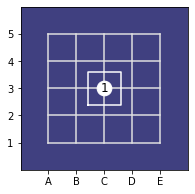

In [5]:
SIZE = 5
kernel_size = 2 * len(rad) + 1
board = GomokuBoard(n=SIZE, disp_width=3, stones=gt.string_to_stones("C3"))
board.display()

In [8]:
sample = create_binary_rep(board.N, board.stones, board.current_color)
print_bin(sample)

shape: (5, 5, 2)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [9]:
filters = [proj1, zero, zero, zero]
filters = np.stack(
    filters, axis=3)
filters = np.reshape(filters, (3, 3, 2, -1))

In [10]:
print_bin(filters[:, :, :, 0])
filters.shape

shape: (3, 3, 2)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

[[ 0.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  0.]]


(3, 3, 2, 4)

In [11]:
sample = np.reshape(sample, [-1, SIZE, SIZE, 2])
biases = [0] * filters.shape[-1]
inf1 = tf.keras.layers.Conv2D(
    filters=len(biases), kernel_size=[kernel_size, kernel_size],
    kernel_initializer=tf.constant_initializer(filters),
    bias_initializer=tf.constant_initializer(biases),
    #    activation=tf.nn.relu,
    padding='SAME',
    input_shape=(SIZE, SIZE, 2))
res = inf1(sample)[0]
for i in range(res.shape[-1]):
    print(res[:, :, i])

tf.Tensor(
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


2022-05-21 16:26:48.297264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
---

# Soft Advice Policy


#### Measuring the stones' influences of the current board

Measure and select from fields that are *strongly* connected to existing stones

In [12]:
radial_off = [.0625, .125, .25, .5]
radial_def = [-.0625, -.125, -.25, -.5]
kernel_size = 2 * len(radial_off) + 1
l_radial = len(radial_off)

In [13]:
# The influence of the current stones under consideration of the defensive power of the other stones
inf_stones_curr = radial_2xnxn(radial_off, radial_def, -10, -10, gamma=1.0)
# The influence of the current influence, discounted
inf_inf_curr = radial_2xnxn(radial_off, radial_def, -10, -10, gamma=.9)
inf_curr = np.stack([inf_stones_curr, inf_inf_curr], axis=-2).reshape((kernel_size, kernel_size, 4))
print_bin(inf_curr[:, :, :2])
print_bin(inf_curr[:, :, 2:])

shape: (9, 9, 2)
[[  0.0625   0.       0.       0.       0.0625   0.       0.       0.
    0.0625]
 [  0.       0.125    0.       0.       0.125    0.       0.       0.125
    0.    ]
 [  0.       0.       0.25     0.       0.25     0.       0.25     0.
    0.    ]
 [  0.       0.       0.       0.5      0.5      0.5      0.       0.
    0.    ]
 [  0.0625   0.125    0.25     0.5    -10.       0.5      0.25     0.125
    0.0625]
 [  0.       0.       0.       0.5      0.5      0.5      0.       0.
    0.    ]
 [  0.       0.       0.25     0.       0.25     0.       0.25     0.
    0.    ]
 [  0.       0.125    0.       0.       0.125    0.       0.       0.125
    0.    ]
 [  0.0625   0.       0.       0.       0.0625   0.       0.       0.
    0.0625]]

[[ -0.0625   0.       0.       0.      -0.0625   0.       0.       0.
   -0.0625]
 [  0.      -0.125    0.       0.      -0.125    0.       0.      -0.125
    0.    ]
 [  0.       0.      -0.25     0.      -0.25     0.      -0.25     

### The influence of the other player's position

In [14]:
# The influence of the other stones under consideration of the defensive power of the current stones
inf_stones_oth = radial_2xnxn(radial_def, radial_off, -1, -1, gamma=1.0)
# The influence of the other influence, discounted
inf_inf_oth = radial_2xnxn([-.0625, -.125, -.25, -.5], [.0625, .125, .25, .5], .9, .9, gamma=.9)
inf_oth = np.stack([inf_stones_oth, inf_inf_oth], axis=-2).reshape((kernel_size, kernel_size, 4))
print_bin(inf_oth[:, :, :2])
print_bin(inf_oth[:, :, 2:])

shape: (9, 9, 2)
[[-0.0625  0.      0.      0.     -0.0625  0.      0.      0.     -0.0625]
 [ 0.     -0.125   0.      0.     -0.125   0.      0.     -0.125   0.    ]
 [ 0.      0.     -0.25    0.     -0.25    0.     -0.25    0.      0.    ]
 [ 0.      0.      0.     -0.5    -0.5    -0.5     0.      0.      0.    ]
 [-0.0625 -0.125  -0.25   -0.5    -1.     -0.5    -0.25   -0.125  -0.0625]
 [ 0.      0.      0.     -0.5    -0.5    -0.5     0.      0.      0.    ]
 [ 0.      0.     -0.25    0.     -0.25    0.     -0.25    0.      0.    ]
 [ 0.     -0.125   0.      0.     -0.125   0.      0.     -0.125   0.    ]
 [-0.0625  0.      0.      0.     -0.0625  0.      0.      0.     -0.0625]]

[[ 0.0625  0.      0.      0.      0.0625  0.      0.      0.      0.0625]
 [ 0.      0.125   0.      0.      0.125   0.      0.      0.125   0.    ]
 [ 0.      0.      0.25    0.      0.25    0.      0.25    0.      0.    ]
 [ 0.      0.      0.      0.5     0.5     0.5     0.      0.      0.    ]
 [ 0.0

### Projectors
Projectors simply pass each stone layer through to the next layer

In [15]:
zero = radial_2xnxn([0] * 4, None, 0, 0)
proj_cur = radial_2xnxn([0] * 4, None, 1, 0)
proj_cur = np.stack([proj_cur, zero], axis=-2).reshape((kernel_size, kernel_size, 4))

proj_oth = radial_2xnxn([0] * 4, None, 0, 1)
proj_oth = np.stack([proj_oth, zero], axis=-2).reshape((kernel_size, kernel_size, 4))

In [16]:
print_bin(proj_oth[:, :, :2])
print_bin(proj_oth[:, :, 2:])

shape: (9, 9, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shape: (9, 9, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 

In [17]:
SIZE = 11

In [18]:
filters = [proj_cur, proj_oth, inf_curr, inf_oth]

biases = [0] * len(filters)

filters = np.stack(filters, axis=3)
filters = np.reshape(filters, (kernel_size, kernel_size, 4, 4))

---

## Verify the policy output

#### Policy layers

In [19]:
inf1 = tf.keras.layers.Conv2D(
    filters=l_radial, kernel_size=kernel_size,
    kernel_initializer=tf.constant_initializer(filters),
    bias_initializer=tf.constant_initializer(biases),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(SIZE, SIZE, 4))

In [20]:
agg = tf.keras.layers.Conv2D(
    filters=1, kernel_size=1,
    kernel_initializer=tf.constant_initializer([-10., -10., .6, .4]),
    bias_initializer=tf.constant_initializer(0.),
    activation=tf.nn.relu,
    padding='same',
    input_shape=(SIZE, SIZE, 4))

In [21]:
samples = {
    'b1c5d3e3e4f2c3d4': 'B6',
    'b1c5d3e3e4f2c2d5': 'F5',
}
examine = 'E6G6'

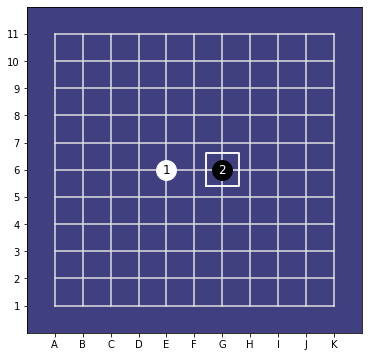

In [22]:
stones = gt.string_to_stones(examine)
board = GomokuBoard(n=SIZE, disp_width=6, stones=stones)
board.display()

In [23]:
sample = create_nxnx4(SIZE, stones)
print_bin(sample[:, :, :2])

shape: (11, 11, 2)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
sample = np.reshape(sample, [-1, SIZE, SIZE, 4])
res = inf1(sample)[0]
res.shape

TensorShape([11, 11, 4])

In [25]:
for i in range(4):
    print(np.squeeze(res[:, :, i]))
    print()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.0625 0.     0.     0.     0.0625 0.     0.     0.     0.0625 0.
  0.    ]
 [0.     0.125  0.     0.     0.125  0.     0.  

In [26]:
res = agg(inf1(sample))
print(np.squeeze(res[0,:,:,0].numpy().round(3)))

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.038 0.    0.025 0.    0.038 0.    0.025 0.    0.038 0.    0.025]
 [0.    0.075 0.    0.05  0.075 0.    0.05  0.075 0.    0.05  0.   ]
 [0.    0.    0.15  0.    0.    0.    0.    0.    0.1   0.    0.   ]
 [0.    0.    0.    0.3   0.3   0.    0.2   0.2   0.    0.    0.   ]
 [0.038 0.075 0.113 0.225 0.    0.    0.    0.15  0.075 0.05  0.025]
 [0.    0.    0.    0.3   0.3   0.    0.2   0.2   0.    0.    0.   ]
 [0.    0.    0.15  0.    0.    0.    0.    0.    0.1   0.    0.   ]
 [0.    0.075 0.    0.05  0.075 0.    0.05  0.075 0.    0.05  0.   ]
 [0.038 0.    0.025 0.    0.038 0.    0.025 0.    0.038 0.    0.025]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [27]:
res = agg(inf1(inf1(sample)))
r_max = tf.math.reduce_max(res)
res = tf.nn.relu(res - r_max * .8)

In [28]:
def vis(tensor):
    npa = np.squeeze(tensor[0,:,:,0].numpy())
    print((npa*99).astype(int))

In [29]:
vis(res)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]


---

#### Find the strongest recommendations within a range of the absolut strongest recommendation

In [30]:
choices = tf.nn.softmax(tf.reshape(res, (SIZE*SIZE))*50).numpy()
elements = range(SIZE*SIZE)
probabilities = choices
actions = [
    gt.m2b(divmod(field, SIZE), SIZE)
    for field in np.random.choice(elements, 100, p=probabilities)]
actions = [ (chr(64+c), r) for c, r in actions]
print(actions)

[('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 5), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('G', 11), ('H', 7), ('H', 5), ('H', 5), ('H', 6), ('H', 6), ('H', 7), ('H', 5), ('H', 6), ('H', 6), ('H', 6), ('J', 5), ('G', 8), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('K', 1), ('H', 6), ('H', 6), ('H', 5), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('D', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 7), ('H', 6), ('H', 6), ('H', 5), ('H', 7), ('H', 6), ('I', 3), ('F', 10), ('H', 6), ('H', 6), ('H', 5), ('H', 6), ('B', 4), ('H', 7), ('H', 6), ('H', 5), ('H', 6), ('H', 6), ('H', 5), ('H', 6), ('H', 6), ('H', 7), ('H', 6), ('K', 10), ('H', 6), ('H', 5), ('H', 6), ('H', 6), ('H', 7), ('H', 7), ('H', 6), ('H', 6), ('H', 7), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 6), ('H', 5), ('H', 5), ('H', 6), ('H', 6), ('A', 1), ('H', 6), ('H', 6), ('H', 7), ('I', 3), ('H', 7), ('H', 6), ('F', 1), ('H', 6), ('H', 6), ('H', 

# Self Play!

In [31]:
SIZE=15
examine = 'H8'

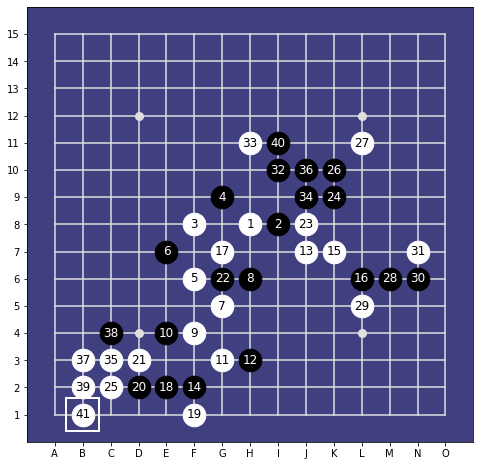

In [36]:
from domoku.constants import BLACK

stones = gt.string_to_stones(examine)
board = GomokuBoard(n=15, disp_width=8, stones=stones)
sample = create_nxnx4(SIZE, stones)
params = MaxInfluencePolicyParams(
    n=15,
    sigma=.4,
    iota=8,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
soft_policy = MaxInfluencePolicy(params, pov=BLACK)

#board.display()
#vis(soft_policy(sample))
move = np.squeeze(soft_policy.sample(sample))
#print(f"Next move: {move}")
for _ in range(40):
    move = gt.m2b(move, 15)
    #print(f"Next Move: {move}")
    board.set(*move)
    sample = create_nxnx4(SIZE, board.stones)
    #board.display()
    #vis(policy(sample))
    move = np.squeeze(soft_policy.sample(sample))
    #print(f"Next move: {move}")
board.display()